# Project 3 - Decision Tree Regression / Random Forest / Boosting - FINAL

## Sophie Wu

## 1. Brief

**[Potential use of findings / project motivation]** <br> Boston presents ample investment opportunities particularly in real estate. Rerouting of highway underground (Central Artery Trunnel Project) and relaxation of Massachusett's "shadow law" opened up space for housing development, presenting new potentials for new  residential property investment. Identifying optimal location and housing characteristics can help investment firms and property development companies maximize returns. <br>


**[Data questions]** <br>
With this in mind, this data analysis project aims to achieve the below:<br>
1) Formulate a model that can predict house prices within 10% of error (as measured by % mean absolute error).<br>
2) Identify the top 3 contributing factors to house prices in Boston and quantify the influence of the variables determing house prices.<br> 


## 2. Load libraries

In [259]:
# for data and matrix manipulation
import pandas as pd
import numpy as np

# for splitting the data into a training and a testing set
from sklearn.model_selection import train_test_split

# for iterations and looping
import itertools

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from statsmodels.graphics.gofplots import qqplot
from sklearn.externals.six import StringIO
from matplotlib.legend_handler import HandlerLine2D

# for regressions
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# for model evaluation
import researchpy as rp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# for tracking progress of iterations
from progressbar import ProgressBar
pbar = ProgressBar()

## 3. Load data

**[Sourcing the relevant data]** <br>
To answer our brief, we use the 'Boston.csv' dataset which contains housing values and other information about Boston suburbs, https://www.kaggle.com/c/boston-housing/overview <br> Alongside price, the dataset also include information on attributes such as (as per below) Crime (CRIM), areas of non-retail business in the town (INDUS); and other attributes which could affect housing supply and demand and thus housing prices in Boston. The dataset is appropriate for our data question.<br>

However, the dataset was originally published in 1978. Average housing prices have since sharply risen so the dataset has some limitations in terms of relevance for today. Nevertheless, we expect underlying drivers of housing prices (more structural and economic factors) to still remain applicable today. <br>

**[Data sharing guidelines]** <br> With respect to data sharing issues and guidelines, this is an open source dataset and can be freely accessed. <br>


In [260]:
# We can access the dataset directly from scikit learn.
from sklearn.datasets import load_boston
boston = load_boston()
type(boston)

sklearn.utils.Bunch

`boston` is a Bunch object. *Bunch* is a subclass of *dict* and is essentially an dictionary.
We transform this to pandas.DataFrame for analysis in below, but first we take a look at its keys to understand the structure of the object and how we should transform the object into a pandas DataFrame.

In [261]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [262]:
# we take a look at the description of the dataset
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

From the description we can see that there are total of 506 observations, 13 explanatory variables (the feature attributes) and MEDV which is the median housing price in $'000, stored as a separate feature in the dictionary object 'target'.

In [263]:
print(boston.data.shape)
print(boston.target.shape)
print(boston.feature_names.shape)

(506, 13)
(506,)
(13,)


We look at the shape of each of the dictionary attribute above. We notice that `boston.data` is a (506,13) ndarray, `boston.target` a (506,) ndarray. We therefore need to append `boston.target` when converting the Bunch object into DataFrame.

In [470]:
# convert object to pandas.DataFrame, embed feature_names as column headings and append boston.target
df = pd.DataFrame(data = boston.data, columns = boston.feature_names)
df['MEDV'] = boston.target

In [471]:
# check the dimensions of the dataset to make sure we have properly converted the object into a DataFrame.
df.shape

(506, 14)

## 4. Explore the data

In [472]:
# check the first 8 observations
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Some column headings are not self-explanatory, we rename some headings below. 

In [473]:
df = df.rename(columns = {"MEDV":"price", "CHAS":"river", "RM":"avg_room", "RAD":"highway_access", "DIS":"jobcentre_distance", 
                          "CRIM":"crime_rate", "ZN":"large_resi", "INDUS":"non_retail_land", "TAX":"tax",
                          "LSTAT":"lower_status", "PTRATIO":"pupilteacher", "AGE":"age", "NOX":"NOx", "B":"black" })
df.head()

,crime_rate,large_resi,non_retail_land,river,NOx,avg_room,age,jobcentre_distance,highway_access,tax,pupilteacher,black,lower_status,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [474]:
# we print information of our data including index dtype and column dtypes, non-null values and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crime_rate            506 non-null float64
large_resi            506 non-null float64
non_retail_land       506 non-null float64
river                 506 non-null float64
NOx                   506 non-null float64
avg_room              506 non-null float64
age                   506 non-null float64
jobcentre_distance    506 non-null float64
highway_access        506 non-null float64
tax                   506 non-null float64
pupilteacher          506 non-null float64
black                 506 non-null float64
lower_status          506 non-null float64
price                 506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


- Dataset contains 506 observations, with no missing values. All variables are numerical (float64). 

In [475]:
# generate descriptive statistics that summarizes the central tendency, dispersion and shape of a dataset's distribution
df.describe(include = 'all')

,crime_rate,large_resi,non_retail_land,river,NOx,avg_room,age,jobcentre_distance,highway_access,tax,pupilteacher,black,lower_status,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


- `price` shows median value of owner-occupied homes in surburbs across Boston on average back in 1978 is roughly $20k. 

- `river` appears to be a dummy variable and can only take on value 0 or 1.

- `highway_access` appears to be a categorical (ordinal) variable with values between 1 to 24.

### 4.1 Variable distributions

Text(0.5,1,'lower_status')

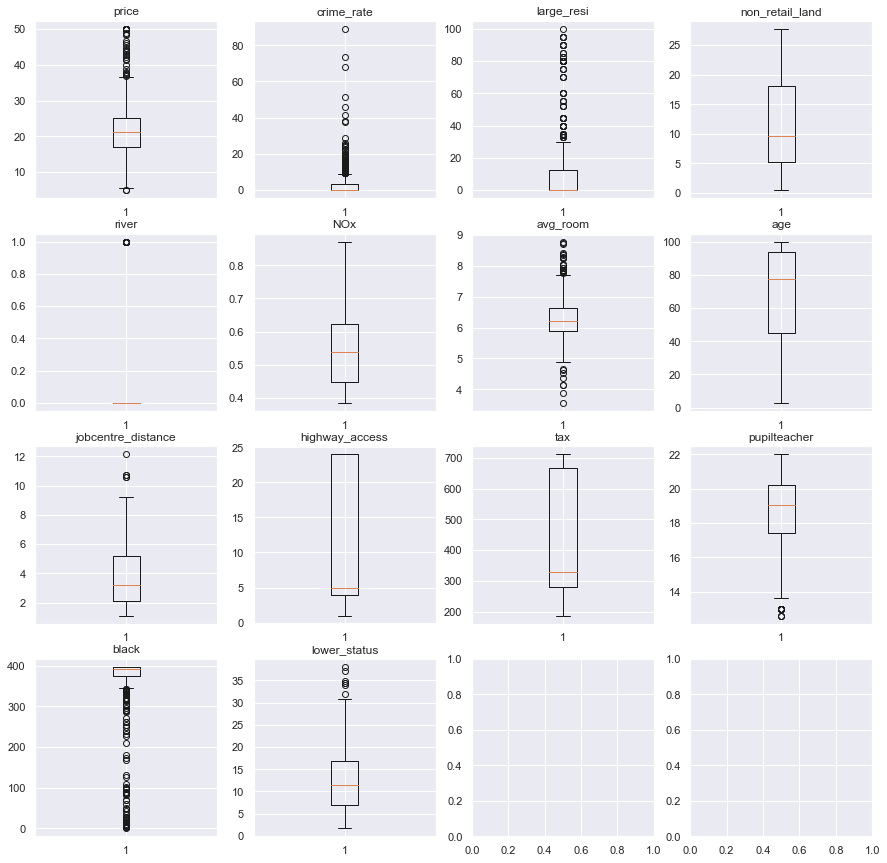

In [270]:
# we take a look at the distribution of the target and feature variables using boxplot followed by histograms

##########
#Boxplots#
##########

fig, axs = plt.subplots(4,4, figsize=(15,15))
axs[0,0].boxplot(df.price)
axs[0,0].set_title("price")
axs[0,1].boxplot(df.crime_rate)
axs[0,1].set_title("crime_rate")
axs[0,2].boxplot(df.large_resi)
axs[0,2].set_title("large_resi")
axs[0,3].boxplot(df.non_retail_land)
axs[0,3].set_title("non_retail_land")
axs[1,0].boxplot(df.river)
axs[1,0].set_title("river")
axs[1,1].boxplot(df.NOx)
axs[1,1].set_title("NOx")
axs[1,2].boxplot(df.avg_room)
axs[1,2].set_title("avg_room")
axs[1,3].boxplot(df.age)
axs[1,3].set_title("age")
axs[2,0].boxplot(df.jobcentre_distance)
axs[2,0].set_title("jobcentre_distance")
axs[2,1].boxplot(df.highway_access)
axs[2,1].set_title("highway_access")
axs[2,2].boxplot(df.tax)
axs[2,2].set_title("tax")
axs[2,3].boxplot(df.pupilteacher)
axs[2,3].set_title("pupilteacher")
axs[3,0].boxplot(df.black)
axs[3,0].set_title("black")
axs[3,1].boxplot(df.lower_status)
axs[3,1].set_title("lower_status")

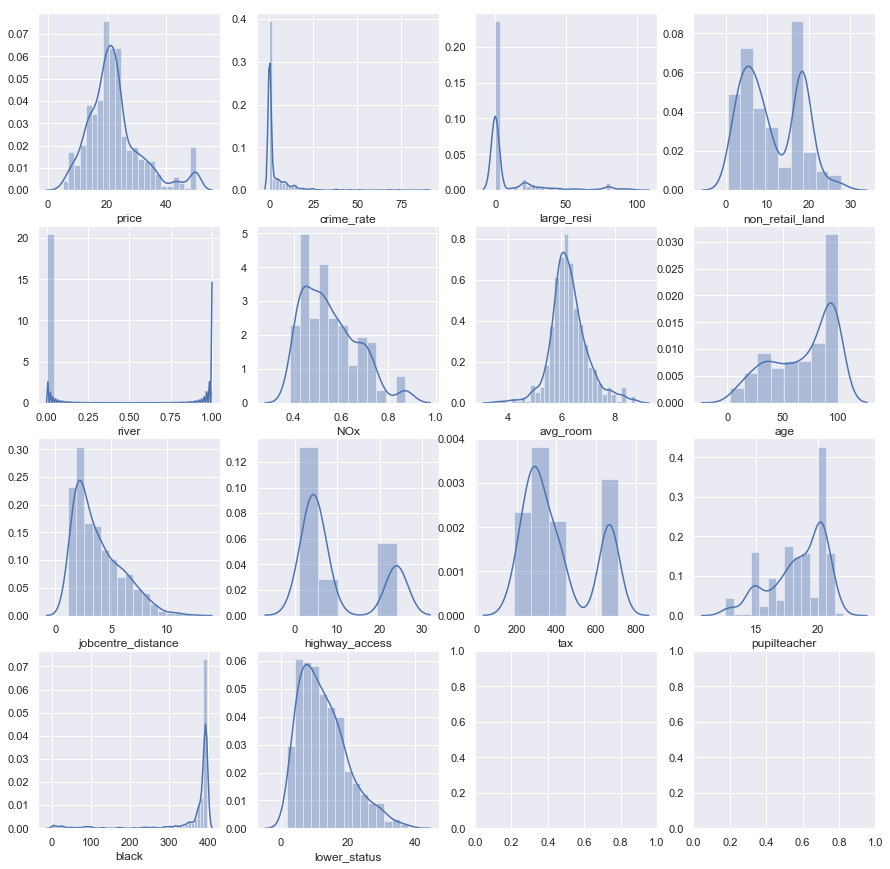

In [271]:
# we take a look at the distribution of the target and feature variables using boxplot followed by histograms

############
#Histograms#
############

sns.set()
f, axes = plt.subplots(4,4, figsize = (15,15))
sns.distplot(df.price, ax=axes[0,0])
sns.distplot(df.crime_rate, ax=axes[0,1])
sns.distplot(df.large_resi, ax=axes[0,2])
sns.distplot(df.non_retail_land, ax=axes[0,3])
sns.distplot(df.river, ax=axes[1,0])
sns.distplot(df.NOx, ax=axes[1,1])
sns.distplot(df.avg_room, ax=axes[1,2])
sns.distplot(df.age, ax=axes[1,3])
sns.distplot(df.jobcentre_distance, ax=axes[2,0])
sns.distplot(df.highway_access, ax=axes[2,1])
sns.distplot(df.tax, ax=axes[2,2])
sns.distplot(df.pupilteacher, ax=axes[2,3])
sns.distplot(df.black, ax=axes[3,0])
sns.distplot(df.lower_status, ax=axes[3,1])

**[What the distribution of variables tell us]** 
- `price` (Median value of owner-occupied homes in $1000's) looks to have a log-normal distribution. For linear or polynomial regression models, it may be ideal to log transform the variable. If the original data approximately follows a log-normal distribution then the log-transformed data would follow a normal or near normal distribution. Similarly for `jobcentre_distance` (weighted distances to five Boston employment centres) and `lower_status` (% lower status of the population), `crime_rate`, `large_resid`, `NOx`.


- `large_resi` (proportion of residential land zoned for lots over 25,000 sq.ft) has a large cluster of observations with value 0. Feature variables lacking variations are unlikely to give much predictive power.


- `avg_room` (average number of rooms per dwelling) appears normally distributed and would therefore make good regressors in OLS estimations without the need for transformation (note that decision tree and RF regressors are robust to non-normal distributions). 


- `non_retail_land` (proportion of non-retail business acres per town) distribution plot suggests there are 2 subgroups (bimodal). 


- `age` (proportion of owner-occupied units built prior to 1940) is negatively skewed (disporportionate amount of owner-occupied units were built prior to 1940 in many suburbs). This makes intuitive sense given Boston is one of the oldest municipalities in the US. 
- *<font color = 'brown'> note: Should we choose to use OLS to model house prices in the sections below, we would need to transform this negatively skewed data. To transform negatively skewed data to a normal distribution, we would need to first reflect then transform (sqrt root OR log OR inverse).  To reflect a variable, we will need to create a new variable where the original value of the variable is subtracted from a constant. The constant is calculated by adding 1 to the largest value of the original variable. The reflect/transform would also apply for negatively distributed variables `pupilteacher` and `black` variables should we choose to use OLS for modelling. </font>*


- `tax` (the full-value property-tax rate per $10,000). A look at the Property Tax and Figures for the City of Boston (https://www.cityofboston.gov/assessing/pdfs/FY02_Fact_Fig_Jan_01.pdf) reveals that commercial properties (c. 35 percent of all property types) incur a higher tax rate (c.3x) than residential properties, which might explains for this bimodal distribution.


- `high_way` (index of accessibility to radial highways) appears to have 2 subgroups (bimodal).


- `river` (Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)) is highly skewed to 0, i.e. a large proportion of houses are not bounded by the river. The variable might not have predicting power due to lack of variation. 


- `B` (1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town). Taking a look at the transformation function applied on Bk (we also plot this function below), we see that Bk cannot be greater than 0.63 (given range of B is 0 - 400). We see from the distribution of B (see boxplot above) that almost all districts' B value is concentrated around c.390, meaning majority of the districts in Boston have's proportion of African-Americans are close to 0. The variable is highly skewed to high values (see boxplot identifying many outliers). Highly skewed variables are problematic for linear and polynomial regressions. and would need tranformation (see comment above re: `age`).

Text(0.5,0,'Bk')

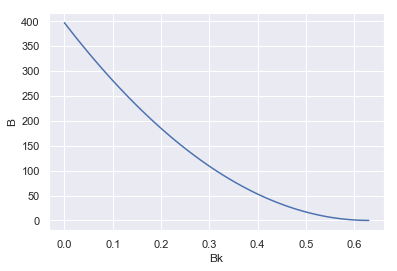

In [272]:
# taking a look at the function applied for the variable `black`
Bk = np.linspace(0,0.63,100) # 100 linearly spaced numbers
B = 1000*(Bk-0.63)**2 # computing the values of sin(x)/x
plt.plot(Bk,B)
plt.ylabel('B')
plt.xlabel('Bk')

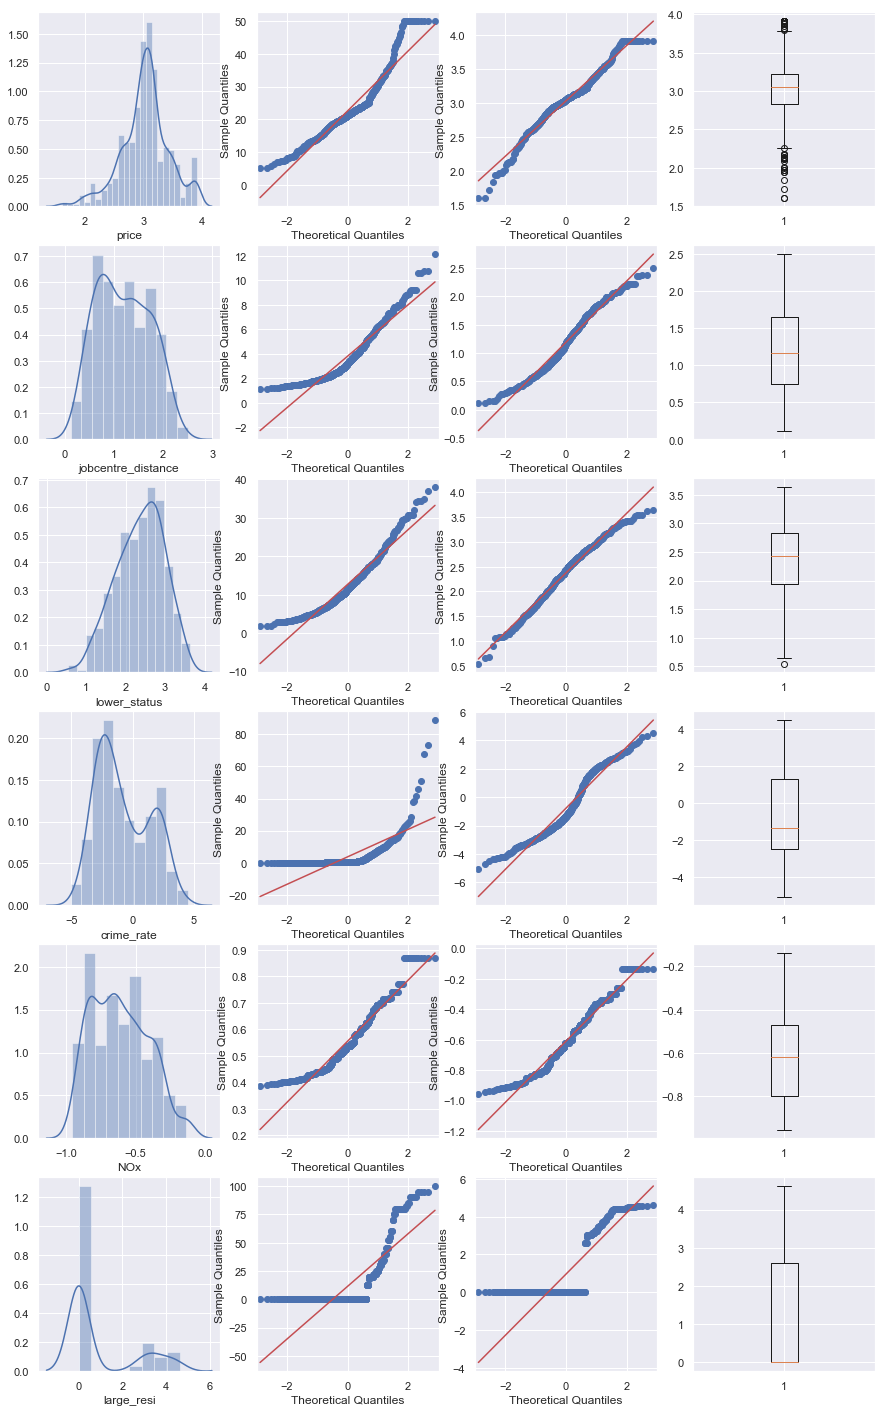

In [273]:
# below we take a look at the distribution of logarithmically transformed variables 
# which appeared to be heavily positively skewed in the previous step

#############################
#positively skewed variables#
#############################

sns.set()
f, axes = plt.subplots(6,4, figsize = (15,25))
sns.distplot(np.log(df.price), ax=axes[0,0])
qqplot(df.price, line='s', ax=axes[0,1])
qqplot(np.log(df.price), line='s', ax=axes[0,2])
axes[0,3].boxplot(np.log(df.price))

sns.distplot(np.log(df.jobcentre_distance), ax=axes[1,0])
qqplot(df.jobcentre_distance, line='s', ax=axes[1,1])
qqplot(np.log(df.jobcentre_distance), line='s', ax=axes[1,2])
axes[1,3].boxplot(np.log(df.jobcentre_distance))

sns.distplot(np.log(df.lower_status), ax=axes[2,0])
qqplot(df.lower_status, line='s', ax=axes[2,1])
qqplot(np.log(df.lower_status), line='s', ax=axes[2,2])
axes[2,3].boxplot(np.log(df.lower_status))

sns.distplot(np.log(df.crime_rate), ax=axes[3,0])
qqplot(df.crime_rate, line='s', ax=axes[3,1])
qqplot(np.log(df.crime_rate), line='s', ax=axes[3,2])
axes[3,3].boxplot(np.log(df.crime_rate))

sns.distplot(np.log(df.NOx), ax=axes[4,0])
qqplot(df.NOx, line='s', ax=axes[4,1])
qqplot(np.log(df.NOx), line='s', ax=axes[4,2])
axes[4,3].boxplot(np.log(df.NOx))

# we +1 to df.large_resi in order to log transform (log(0) undefined)
sns.distplot(np.log(df.large_resi+1), ax=axes[5,0])
qqplot(df.large_resi, line='s', ax=axes[5,1])
qqplot(np.log(df.large_resi+1), line='s', ax=axes[5,2])
axes[5,3].boxplot(np.log(df.large_resi+1));


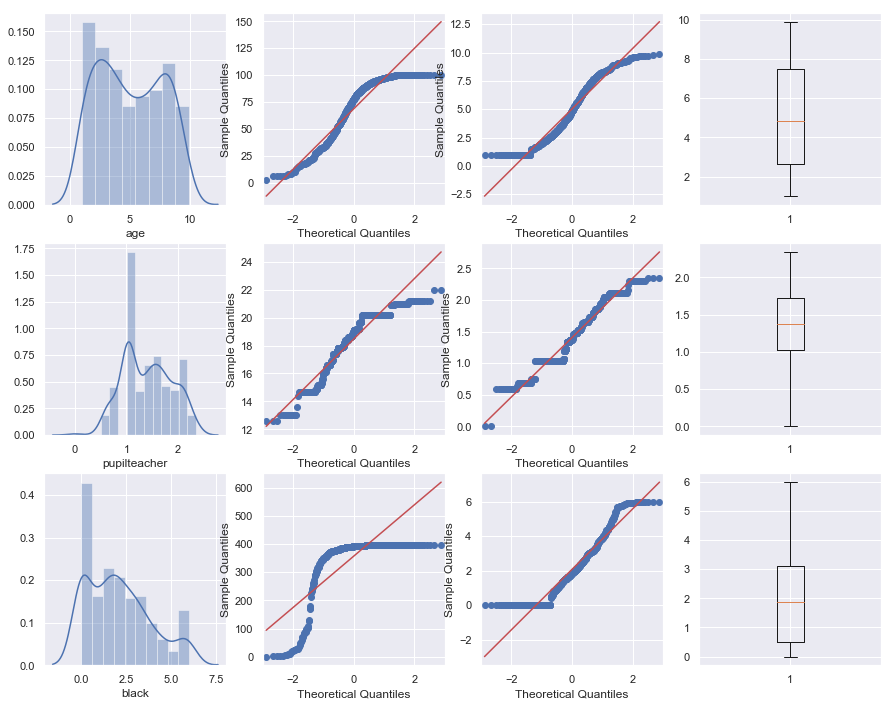

In [274]:
#############################
#negatively skewed variables#
#############################

# we choose between square root transformation and log transformation dependent on severity of skewness.
sns.set()
f, axes = plt.subplots(3,4, figsize = (15,12))

sns.distplot((max(df.age)+1-df.age)**0.5, ax = axes[0,0])
qqplot(df.age, line ='s', ax=axes[0,1])
qqplot((max(df.age)+1-df.age)**0.5, line='s', ax=axes[0,2])
axes[0,3].boxplot((max(df.age)+1-df.age)**0.5)

sns.distplot(np.log(max(df.pupilteacher)+1-df.pupilteacher), ax=axes[1,0])
qqplot(df.pupilteacher, line='s', ax=axes[1,1])
qqplot(np.log(max(df.pupilteacher)+1-df.pupilteacher), line='s', ax=axes[1,2])
axes[1,3].boxplot(np.log(max(df.pupilteacher)+1-df.pupilteacher))

sns.distplot(np.log(max(df.black)+1-df.black), ax=axes[2,0])
qqplot(df.black, line='s', ax=axes[2,1])
qqplot(np.log(max(df.black)+1-df.black), line = 's', ax=axes[2,2])
axes[2,3].boxplot(np.log(max(df.black)+1-df.black));


**[What transformed distributions tell us]** 
- Distribution of log transformed variables suggests `crime_rate`  to have 2 subgroups, as does `non_retail_land`, `large_resid` and `age`. This is problematic for linear regressions for examples. we may choose to omit these variables as regressors should we choose to do linear regressions / split the data into distinct variables (categorical/dummy variables), alternatively we may decide to use regression methods that are robust to non-normal relationships, e.g. decision tree regressions.

In [275]:
# we define and append the above transformed variables to a new DataFrame tf_df 
# in case they may be of use in future steps.
tf_df=pd.DataFrame()
tf_df['tf_price'] = np.log(df.price)
tf_df['tf_lower_status'] = np.log(df.lower_status)
tf_df['tf_crime_rate'] = np.log(df.crime_rate)
tf_df['tf_NOx'] = np.log(df.NOx)
tf_df['tf_large_resi'] = np.log(df.large_resi+1)
tf_df['tf_age'] = np.sqrt((max(df.age)+1-df.age))
tf_df['tf_pupilteacher'] = np.log(max(df.pupilteacher)+1-df.pupilteacher)
tf_df['tf_black'] = np.log(max(df.black)+1-df.black)
tf_df.head()

,tf_price,tf_lower_status,tf_crime_rate,tf_NOx,tf_large_resi,tf_age,tf_pupilteacher,tf_black
0,3.178054,1.605430,-5.064036,-0.619897,2.944439,5.983310,2.041220,0.000000
1,3.072693,2.212660,-3.600502,-0.757153,0.000000,4.701064,1.648659,0.000000
2,3.546740,1.393766,-3.601235,-0.757153,0.000000,6.316645,1.648659,1.623341
3,3.508556,1.078410,-3.430523,-0.780886,0.000000,7.429670,1.458615,1.184790
4,3.589059,1.673351,-2.672924,-0.780886,0.000000,6.841053,1.458615,0.000000


### 4.2. Correlation Analysis

In this step we explore correlation of variables.

In [476]:
# sort correlation of feature variables to the target variable from positive to negative.
corr = df.corr()
corr['price'].sort_values(ascending = False)

price                 1.000000
avg_room              0.695360
large_resi            0.360445
black                 0.333461
jobcentre_distance    0.249929
river                 0.175260
age                  -0.376955
highway_access       -0.381626
crime_rate           -0.385832
NOx                  -0.427321
tax                  -0.468536
non_retail_land      -0.483725
pupilteacher         -0.507787
lower_status         -0.737663
Name: price, dtype: float64

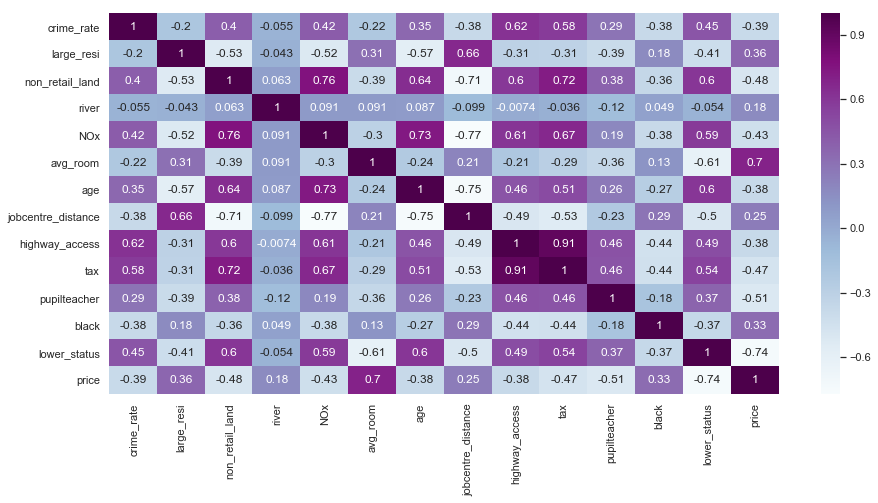

In [477]:
# we plot a correlation matrix below of all 14 variables to further explore relationships between variables.
sns.set(font_scale = 1)
plt.figure(figsize = (15,7))
sns.heatmap(corr, annot = True, cmap = 'BuPu')

- `price` is highly correlated with `avg_room` (+ve) and `lower_status` (-ve). This makes intuitive sense: houses in areas with higher socieconomic status and more bedrooms are likely more expensive. 


- We see that `tax` and `highway_access` are almost perfectly correlated +0.91. This would distort a linear regression model (multicollinearity problem). The same applies to `age` and `NOx` (-0.75); `age` and `jobcentre_distance` (0.75); `NOx` and `non_retail_land` (0.76); `jobcentre_distance` and `NOx` (-0.77); `non_retail_land` and `tax` (0.72); `jobcentre_distance` and `non_retail_land` (-0.71). 


Correlation and correlation matrix will not pick up non-linear relationships between variables. 
We may still be interested in knowing whether any non-linear relationships exist between variables with the aim to reduce the amount of parameters our model needs to fit. We therefore present pairplots below for all 14 variables. 


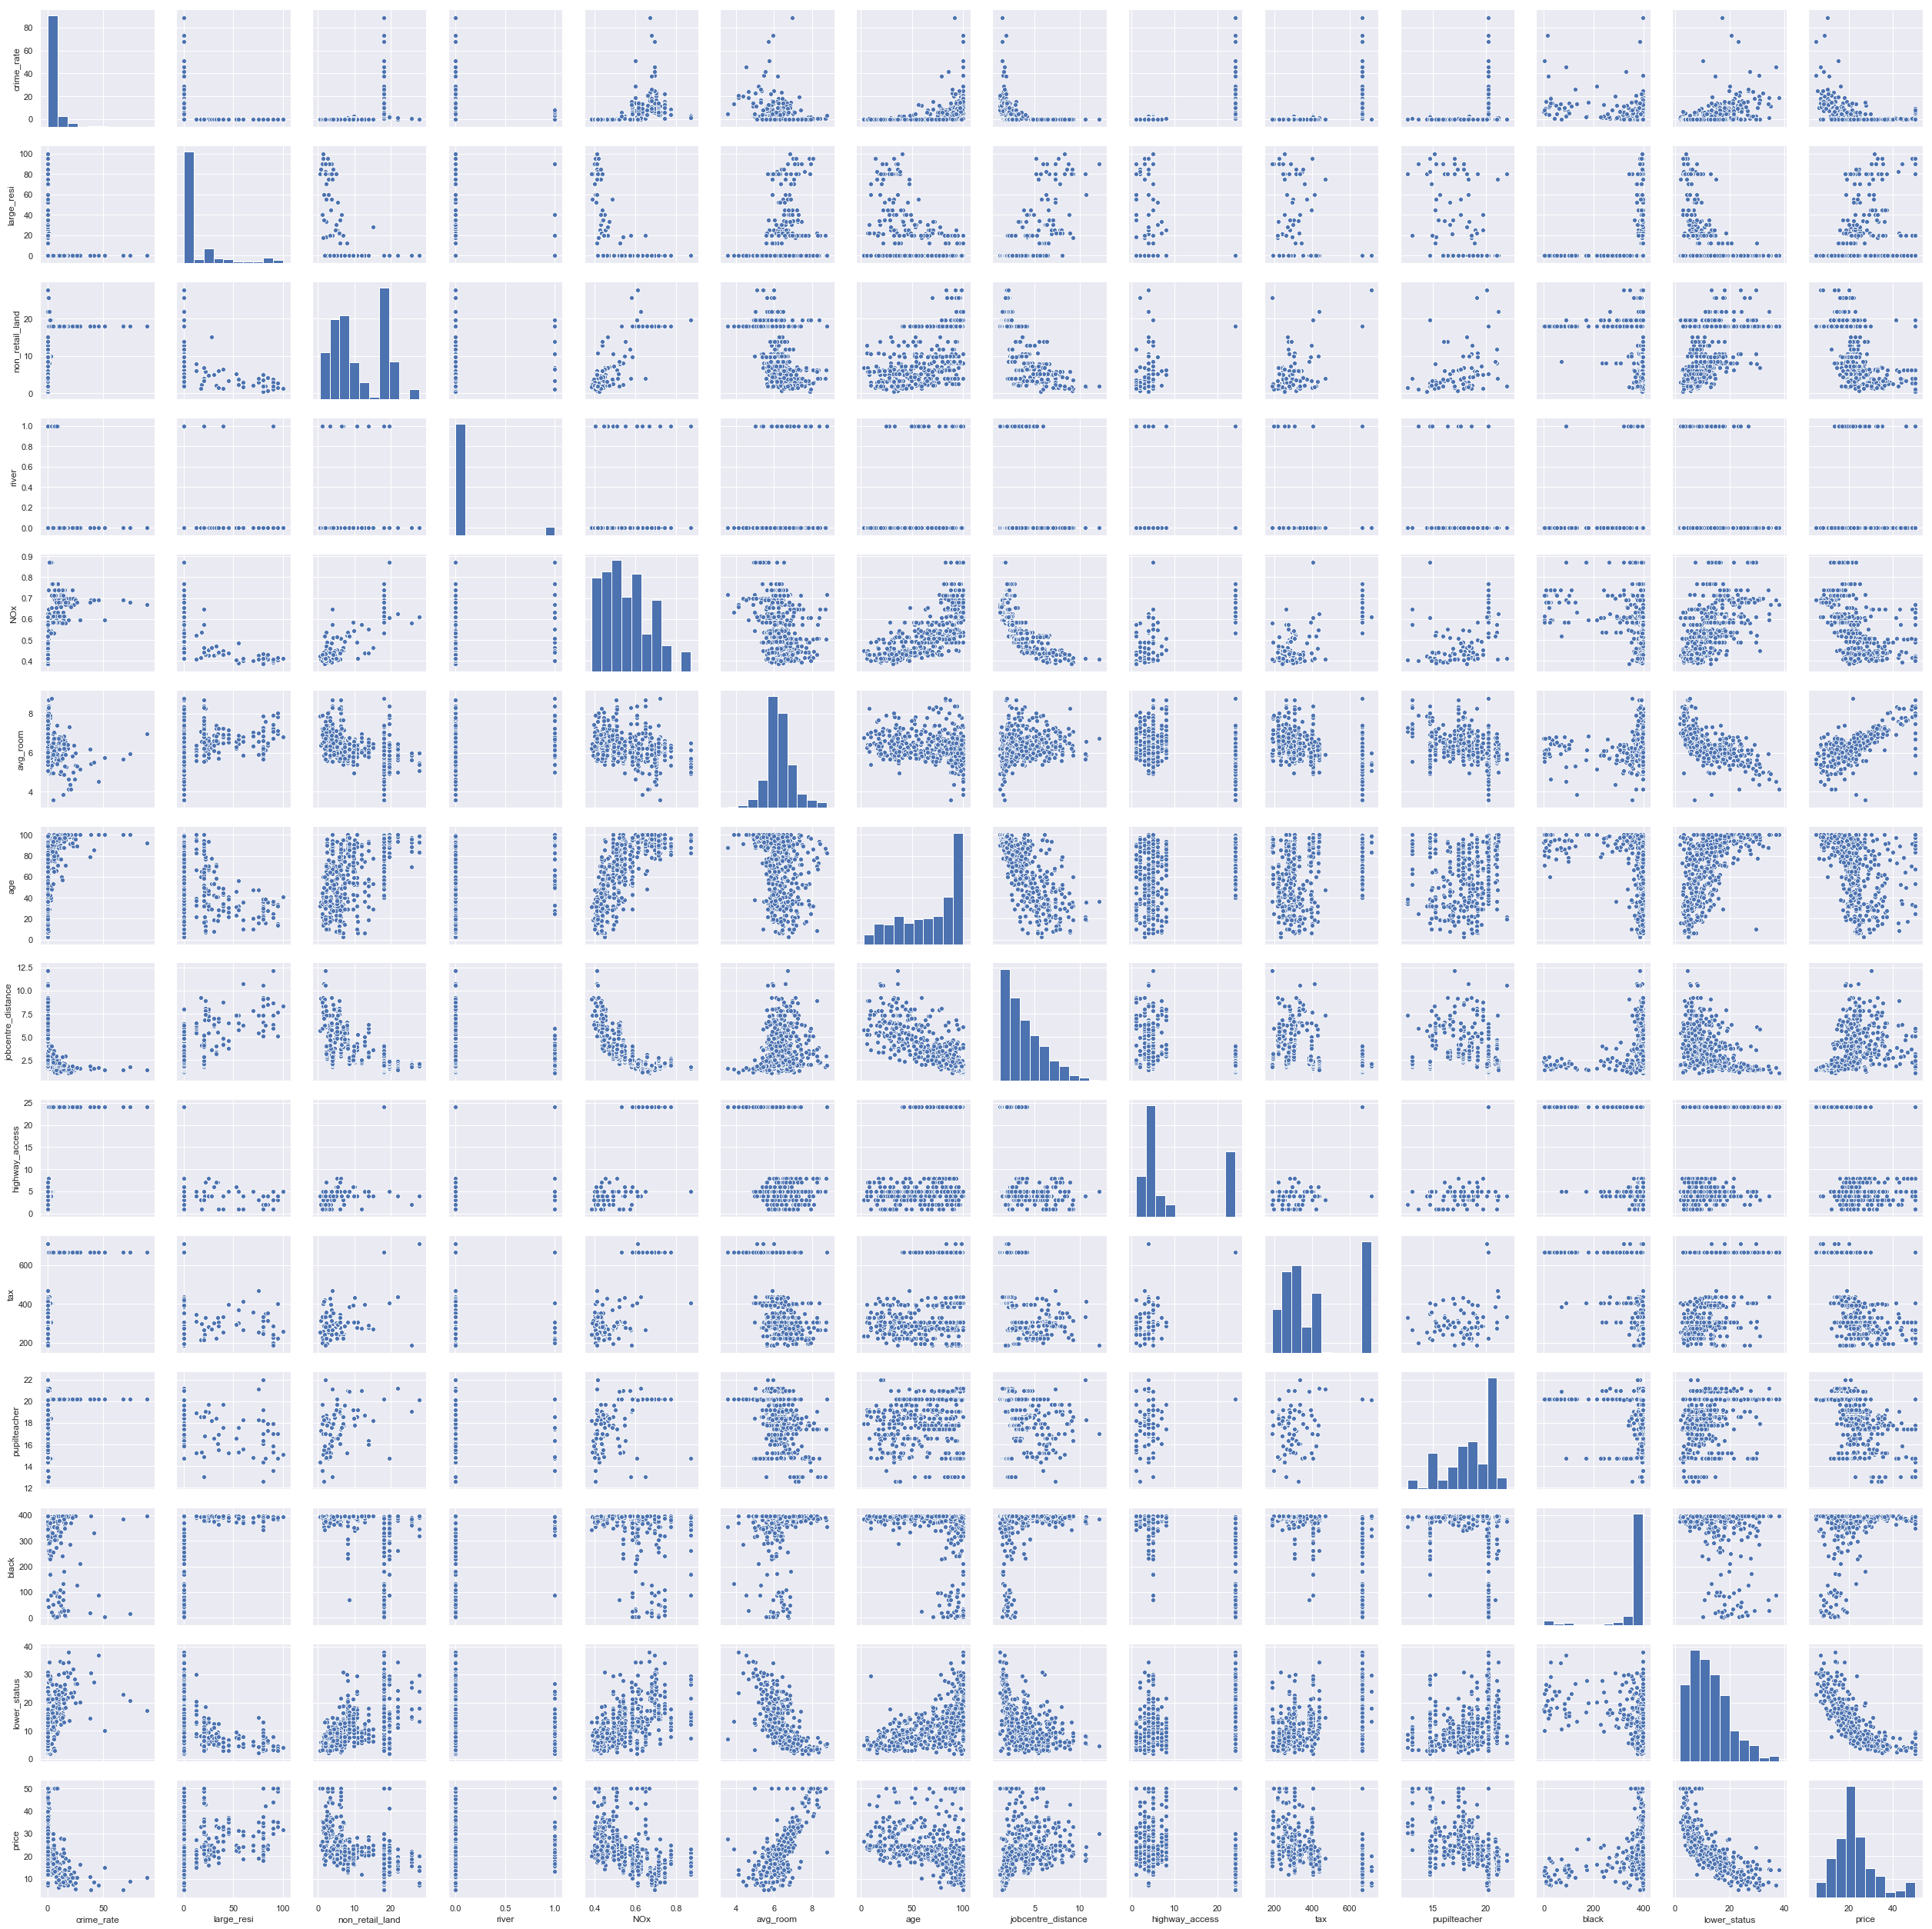

In [278]:
sns.pairplot(df)

- There is a strong, though non-linear, negative relationship between `crime_rate` and `large_resid`: when `crime_rate` is high, `large_resid` is zero and when `large_resid` is high, `crime_rate` is very low and close to zero. An explanation might be that downtown districts (which typically do not have residential land zoned for lots >250,000sqft) are more likely to have higher crime rate. We also see negative relationships between `crime_rate` and several other feature variables.

## 5. Regression Model

**[Model Choice]**<br>
Our data exploration step highlighted non-normal distributions for many of the feature variables which would require transformations (log, sqrt, inverse, reflect) for linear regression modelling (and other parametric modelling techniques). Even post transformation, several of the variables exhibit bi-modal distributions. In a linear regression context, we may need to split the data and create variables (e.g. for `large_resid` to split into brackets of low and high zoning density). Box plots of transformed variables also hints to potential outliers in the data of the target variable `price` which would distort linear regression models. Highly correlated feature variables lead to multicollineary problem for linear regression models.

Tree based regressions are robust to distributions (can deal with non-normal/bimodal etc. being non-parametric methods), multicollinearity as well as to outliers and can offer simple interpretations (more so in simple decision tree models and less so in ensemble methods; it is more difficult to interpret coefficients of transformed regressors in linear regressions vs. identifying feature importance in tree-based models). 

For these reasons, we decide to use tree-based models for our predictions.

### 5.1. Regression Trees  - *tree.DecisionTreeRegressor(  )*

We will first run a full tree without dimension reduction/feature selection or restricting the length of the tree.

**[Growing a full tree]**

In [478]:
# feature selection
feature_cols = [
    'crime_rate',
    'large_resi',
    'non_retail_land',
    'river',
    'NOx',
    'avg_room', 
    'age', 
    'jobcentre_distance', 
    'highway_access', 
    'tax',
    'pupilteacher', 
    'black', 
    'lower_status']

X = df[feature_cols]
y = df.price

# subset X and y into X_train, X_test, y_train, y_test using the train_test_split function
# we have enough observations for a 20/80 test/train split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [479]:
# print the shapes of the training and test set to verify if the splitting was done properly.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(404, 13)
(404,)
(102, 13)
(102,)


Feature importance: 
avg_room              0.619117
lower_status          0.210373
jobcentre_distance    0.060422
crime_rate            0.039482
NOx                   0.022747
pupilteacher          0.012574
tax                   0.011865
age                   0.007254
black                 0.005961
non_retail_land       0.005492
highway_access        0.003492
large_resi            0.001064
river                 0.000157
dtype: float64
------------------------------
Nodes: 743
------------------------------


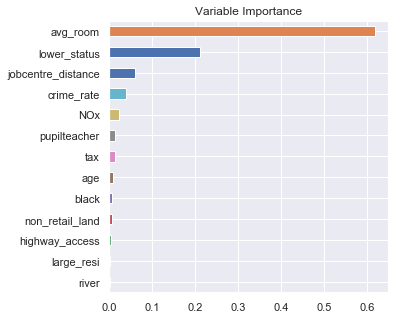

In [480]:
# we first run a fully grown and unpruned tree
regr_full = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123)
regr_full.fit(X_train, y_train)
y_pred_full = regr_full.predict(X_test)
y_pred_full = pd.Series(y_pred_full)

# check which variables are the most important
feature_importances_full = pd.Series(regr_full.feature_importances_, index = X.columns)
feature_importances_full = feature_importances_full.sort_values()
print("Feature importance: ")
print(feature_importances_full.sort_values(ascending = False))
print("------------------------------")

# take a look at the depth of the tree/number of nodes
print("Nodes:", regr_full.tree_.node_count)
print("------------------------------")

# visualise feature importance
feature_importances_full.plot(kind = 'barh', figsize = (5,5))
plt.title("Variable Importance")
sns.set(font_scale = 1)

- With our tree being a full one and unpruned, all 13 features were used in the tree. 


- Comparing feature importance with the correlation matrix above, we see that `avg_room` and `lower_status` which were identified as being individually highly correlated with `price`, are the two most important features in our full tree. `river` which had the lowest correlation with `price` is also the least important feature. `large_resi` which had low variation and for which we expected low predictive is also an unimportant factor. 



- Variables following `avg_room` and `lower_status` identified in feature importance are `jobcentre_distance`, `crime_rate`, `NOx`, `pupilteacher_ratio` which have comparatively low correlation to `price` compard to other  feature variables. However, looking at the correlation matrix and pairplot, we see that `jobcentre_distance`, `crime_rate` and `NOx` are more correlated to the other feature variables, thus once controlling for these factors,  the importance of other factors is significantly reduced since effectively the impurity they can remove is already removed by the first feature. This also explains for why magnitude of feature importance see a significant drop after `avg_room`.


- There are 743 nodes to the unpruned fully grown regression tree (a very large tree that'll be difficult to interpret and visualise). Though robust to variable distributions and outliers, a problem with tree-based regression is the danger of overfitting. We prune our tree in the fellowing steps with feature selection and tree depth limitation. 


- First, we take a look at the MSE to see how well our model fit the test data. We also calculate '%MAE' (percentage mean absolute error) to see if this model satisfies our objective for prediction accuracy.

In [24]:
# calculating percentage mean absolute error
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)

    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

MSE:  45.587254902
RMSE: 6.75183344744
%MAE:  19.5446597946


Text(0.5,1,'Decision Tree Regression')

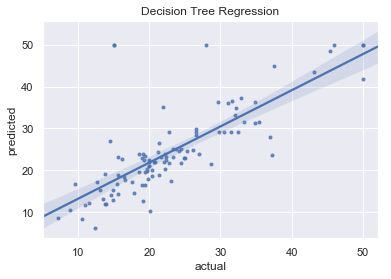

In [25]:
# look at the MSE to get a sense of the quality of the fit
print("MSE: ",  mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("%MAE: ", mean_absolute_percentage_error(y_test, y_pred))

# Plot predicted `price` against actual values
sns.regplot(x=y_test, y=y_pred, marker='.')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("Decision Tree Regression")

- The test set MSE associated with the regression tree is 45.6. The sqrt of MSE is around 6.75, indicating that this model leads to test predictions that are within around $6750 of the true median home value for the suburb. %Mean absolute error is c.19.5%, this is too large for the model to be useful in a business context and does not satisfy our brief. 

**[Pruning the tree: #1 feature selection]**
- Tree-based approach's recursive binary splitting is an example of a 'greedy' algorithm. It is greedy because at each step of the tree-building process, the best split is made at that particular step rather than looking ahead and picking a split that will lead to a better tree in some future step. 


- Below we run iterations, varying the number and combinations of features we use for a full-tree regression. 

In [167]:
# feature selection
feature_cols = ['crime_rate',
                'large_resi',
                'non_retail_land',
                'river',
                'NOx',
                'avg_room', 
                'age', 
                'jobcentre_distance', 
                'highway_access', 
                'tax',
                'pupilteacher', 
                'black', 
                'lower_status']


# create dataframe to be filled with appended dataframes from our loop
data_i_need = pd.DataFrame()
for j in range(1,13):

    l = []
    
    # we loop through all combinations choose from 1 to 13 variables
    result = itertools.combinations(feature_cols,j)
    
    # we define a loop to iterate through `result`
    # first create a dataframe to be filled with model evaluation metrics we are interested in
    foo_3 = pd.DataFrame({'Feature': [],'Nodes': [], 'MSE': [], 'RMSE': [], '%MAE': []})
    
    for each in result:
        l.append(each)

    for i in range(0,len(l)):
        feat = list(l[i])
        X = df[feat]
        y = df.price
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        regr_full = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123)
        regr_full.fit(X_train, y_train)
        y_pred = regr_full.predict(X_test)
        y_pred = pd.Series(y_pred)
        
        # we append the evaluation metrics we get for each iteration into a single table
        foo_3 = foo_3.append({'Feature': list(X.columns), 'Nodes':regr_full.tree_.node_count,
                              'MSE': mean_squared_error(y_test, y_pred),
                              'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)), 
                              '%MAE': mean_absolute_percentage_error(y_test, y_pred)}, ignore_index=True)        
    
    # we append individual dataframes
    data_i_need = data_i_need.append(foo_3, ignore_index=True)

# we sort table from low to high RMSE
data_i_need = data_i_need.sort_values(by=['RMSE'])
data_i_need = data_i_need.reset_index(drop=True)
data_i_need.head()

,Feature,Nodes,MSE,RMSE,%MAE
0,"[crime_rate, large_resi, non_retail_land, NOx,...",767.0,13.733725,3.705904,13.573039
1,"[crime_rate, non_retail_land, avg_room, highwa...",771.0,14.931471,3.864126,13.156771
2,"[crime_rate, large_resi, non_retail_land, NOx,...",771.0,15.039118,3.878030,13.381665
3,"[crime_rate, large_resi, NOx, avg_room, age, h...",767.0,15.241863,3.904083,13.521395
4,"[crime_rate, large_resi, non_retail_land, rive...",767.0,15.432059,3.928366,14.275956


In [171]:
print(data_i_need.iloc[0]['Feature'])

['crime_rate', 'large_resi', 'non_retail_land', 'NOx', 'avg_room', 'age', 'tax', 'pupilteacher', 'black', 'lower_status']


In [166]:
# create a list variable to be fill with tuples containing combinations of features
l = []

result = itertools.combinations(feature_cols,3)

foo_3 = pd.DataFrame({'Feature': [],'Nodes': [], 'MSE': [], 'RMSE': [], '%MAE': []})
data = pd.DataFrame()
for each in result:
    l.append(each)

for i in range(0,len(l)):
    feat = list(l[i])
    X = df[feat]
    y = df.price
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    regr_full = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123)
    regr_full.fit(X_train, y_train)
    y_pred = regr_full.predict(X_test)
    y_pred = pd.Series(y_pred)
    foo_3 = foo_3.append({'Feature': list(X.columns), 'Nodes':regr_full.tree_.node_count,
                              'MSE': mean_squared_error(y_test, y_pred),
                              'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)), 
                              '%MAE': mean_absolute_percentage_error(y_test, y_pred)}, ignore_index=True)
        
print(len(foo_3))
foo_3.sort_values(by=['RMSE']).head()

286


,Feature,Nodes,MSE,RMSE,%MAE
44,"[crime_rate, avg_room, lower_status]",769.0,23.295196,4.826510,15.128357
283,"[tax, pupilteacher, lower_status]",775.0,24.746144,4.974550,17.455638
162,"[non_retail_land, tax, lower_status]",777.0,29.210261,5.404652,17.687264
198,"[river, tax, lower_status]",777.0,29.442037,5.426052,18.425138
164,"[non_retail_land, pupilteacher, lower_status]",779.0,29.981144,5.475504,17.488545


We further improved RMSE with 10 features to $3706 (though %MAE is still below our target level). Below we list the top 3 factors in this 10 feature model.

Feature importance: 
avg_room           0.587035
lower_status       0.256552
crime_rate         0.070951
NOx                0.025292
non_retail_land    0.018398
tax                0.013539
pupilteacher       0.010184
black              0.008592
age                0.008245
large_resi         0.001211
dtype: float64
------------------------------
Nodes: 767
------------------------------
MSE:  13.7337254902
RMSE: 3.70590413937
%MAE:  13.5730386652


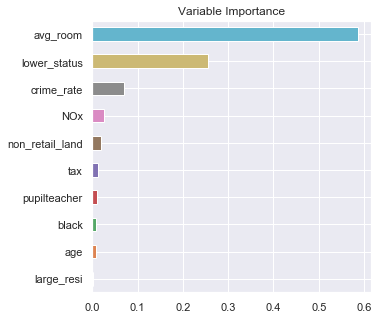

In [486]:
# feature selection
feature_cols = ['crime_rate', 
                 'large_resi', 
                 'non_retail_land', 
                 'NOx', 'avg_room', 
                 'age', 'tax', 
                 'pupilteacher', 
                 'black', 
                 'lower_status']

X = df[feature_cols]
y = df.price

# subset X and y into X_train, X_test, y_train, y_test using the train_test_split function
# we have enough observations for a 20/80 test/train split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
                
regr_full = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123)
regr_full.fit(X_train, y_train)
y_pred_10 = regr_full.predict(X_test)
y_pred_10 = pd.Series(y_pred_10)

# check which variables are the most important
feature_importances_full = pd.Series(regr_full.feature_importances_, index = X.columns)
feature_importances_full = feature_importances_full.sort_values()
print("Feature importance: ")
print(feature_importances_full.sort_values(ascending = False))
print("------------------------------")

# take a look at the depth of the tree/number of nodes
print("Nodes:", regr_full.tree_.node_count)
print("------------------------------")
print("MSE: ",  mean_squared_error(y_test, y_pred_10))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_10)))
print("%MAE: ", mean_absolute_percentage_error(y_test, y_pred_10))

# visualise feature importance
feature_importances_full.plot(kind = 'barh', figsize = (5,5))
plt.title("Variable Importance")
sns.set(font_scale = 1)

- `avg_room`, `lower_status` and `crime_rate` are the top 3 contributing factors to housing prices in Boston. `river`, `high_way` and `jobcentre_distance` fell out of list as contributing factors to housing prices. It is surprising to see `jobcentre_distance` complete falling out of the list, given it was the third most important factor identified in the unpruned tree. This requires further analysis.

**[Pruning the tree - #2 limiting max_depth]**
- We  attempt to fine tune the max_depth parameter.
- Smaller tree with fewer split might lead to better interpretation.
- We look at what is optimal max_depth for the tree by plotting max_depth against MSE.
- We start off with the 10 feature model identified above.
- MSE settled down to a minimum at depth = 18, at RMSE of 3.70.
- Tree of depth 20 is still too deep to visualise.
- Below we run a tree with max_depth = 6 for visualisation and interpretation purposes.

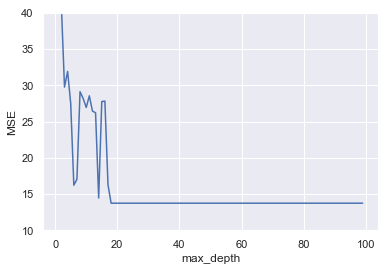

In [489]:
# iterate through max_depth using simple decision tree 
max_depth = range(1,100,1)
test_results = []
for i in max_depth:
   dt = tree.DecisionTreeRegressor(max_depth = i, random_state = 123)
   dt.fit(X_train, y_train)
   y_pred = dt.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_results.append(mse)
plt.plot(max_depth, test_results)
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.ylim(10,40)
sns.set(font_scale = 1)

In [490]:
# we run a pruned tree with max_depth = 6
regr_pruned = tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123, max_depth = 6)
regr_pruned.fit(X_train, y_train)
y_pred_pruned = regr_pruned.predict(X_test)
y_pred_pruned = pd.Series(y_pred_pruned)

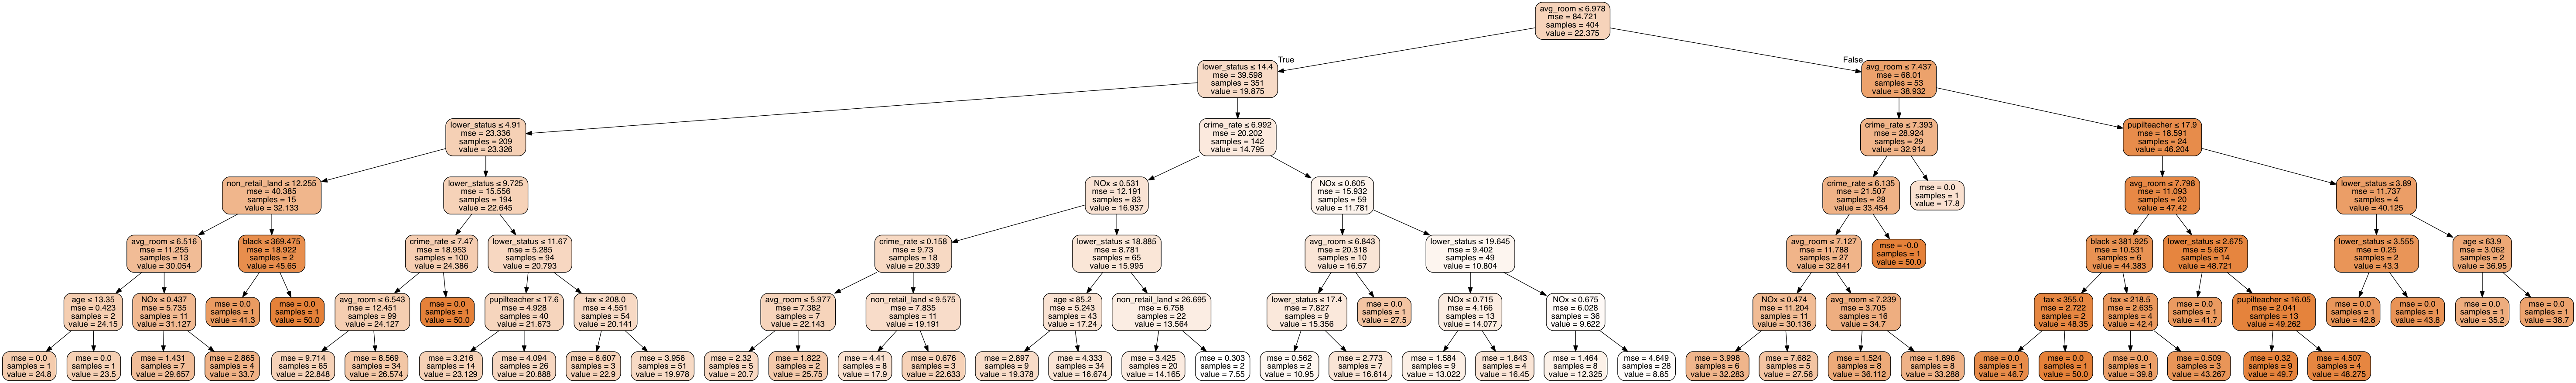

In [188]:
# visualising the tree 
dot_data = StringIO()
tree.export_graphviz(regr_pruned, out_file = dot_data, 
                     filled = True, rounded = True, special_characters = True, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

- A house would have the lowest value (with median value $7,550) if: house is small, in poor and unsafe area, with high pollution, high proportion of population with low socioeconomic status.
 - average number of rooms (`RM`) is < 7 (i.e. small house)
 - % of individuals with lower economic status in the area (`LSTAT`) is > 18.9% (i.e. poor surrouding area)
 - per capita crime rate > 7% (i.e. unsafe)
 - nitrogen dioxide concentration > 0.5 parts per million. (i.e. high pollution)
 - proportion of non-retail business acres per town > 27 (i.e. near industrial area that's noisy and highly polluted).
 
 
 
- A house would have the highest value (with median value ($50,000) if: house is big and close to a good school, with high property tax.
 - average number of rooms (`RM`) is > 7 (i.e. big house)
 - pupil teacher ratio < 18 (i.e. a good school)
 - property tax > 355
 

### 5.2. Random Forest - *RandomForestRegressor( )*

- Decisions trees suffer from high variance. The results of different train/test splits of dataset (with different random_state) are often quite different. This is to say that the 10 variable model we identified above yielding the lowest MSE might not apply should we have split the train/test data differently (we show graphically that this is indeed the case). For this reason, we can't yet conclude that `avg_room`, `lower_status` and `crime_rate` are the top 3 contributing factors to house prices. Further the prediction accuracy of our 10 variable model didn't satify the target we set out in the brief.


- We explore ensemble methods (Random Forest and Boosting) in the sections below to try improve prediction and stability of our model.


- Random Forest models have lower variance and will yield similar results if applied repeated to distinct data sets; averaging across multiple decision trees on bootstrapped training samples reduces variance. Further, when building the decision trees, each time a split in a tree is considered, a random sample of predictors is chosen as split candidates from the full set of predictors thereby decorrelating the trees and to a certain extent reduces the 'greedy algorithm' problem of simple decision trees. 


- Below we iterate through random_states using both *DecisionTreeRegressor()* and *RandomForestRegressor()* and visualise the variance in the MSEs.


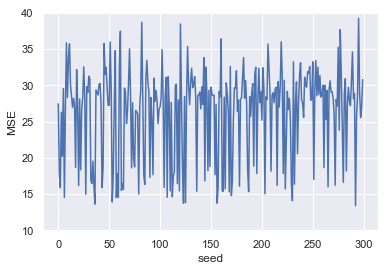

In [245]:
# iterate through random_state using simple decision tree 
seed = range(0,300)
test_results = []
for i in seed:
   dt = tree.DecisionTreeRegressor(random_state = i)
   dt.fit(X_train, y_train)
   y_pred = dt.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_results.append(mse)
plt.plot(seed, test_results)
plt.ylabel('MSE')
plt.xlabel('seed')
plt.ylim(10,40)
sns.set(font_scale = 1)

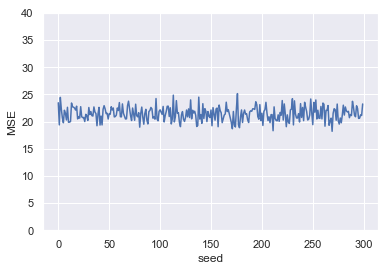

In [244]:
# iterate through random_states using Random Forest
seed = range(0,300)
test_results = []
for i in seed:
   dt = RandomForestRegressor(n_estimators=50, random_state = i)
   dt.fit(X_train, y_train)
   y_pred = dt.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_results.append(mse)
plt.plot(seed, test_results)
plt.ylabel('MSE')
plt.xlabel('seed')
plt.ylim(0,40)
sns.set(font_scale = 1)

- We see that Random Forest produces much more stable models with smaller variance in MSE.


- The number of trees is not a critical parameter with Random Forests. Using a large number for *n_estimators* will not lead to overfitting. We therefore set up the model with a *n_estimators* (number of trees) large enough such that the error stabilizes. Our iterations below show that the error stabilises around c.500 trees. We also use all feature variables in our Random Forest model given the method is more robust to the 'greedy algorithm' problem. 



In [280]:
# finding and visualising the optimal n_estimator with the lowest MSE
# feature selection
feature_cols = ['crime_rate',
                'large_resi',
                'non_retail_land',
                'river',
                'NOx',
                'avg_room', 
                'age', 
                'jobcentre_distance', 
                'highway_access', 
                'tax',
                'pupilteacher', 
                'black', 
                'lower_status']

X = df[feature_cols]
y = df.price

# subset X and y into X_train, X_test, y_train, y_test using the train_test_split function
# we have enough observations for a 20/80 test/train split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

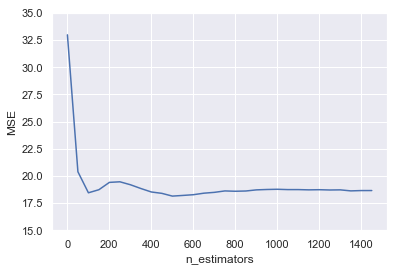

In [281]:
# we iterate through the parameter n_estimators
n_estimator = range(1,1500, 50)
test_results = []
for estimator in n_estimator:
   bst = RandomForestRegressor(criterion = 'mse', random_state = 123,
                               n_estimators=estimator)
   bst.fit(X_train, y_train)
   y_pred = bst.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_results.append(mse)
plt.plot(n_estimator, test_results)
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.ylim(15,35)
sns.set(font_scale = 1)

Feature importance: 
avg_room              0.540156
lower_status          0.300788
jobcentre_distance    0.049605
crime_rate            0.029243
NOx                   0.020510
tax                   0.015273
pupilteacher          0.012591
age                   0.012145
black                 0.008979
non_retail_land       0.004786
highway_access        0.003859
large_resi            0.001121
river                 0.000944
dtype: float64
------------------------------
MSE:  18.6563612837
RMSE: 4.31930101796
%MAE:  11.9857081557


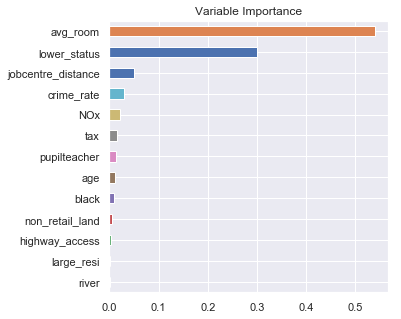

In [282]:
X = df[feature_cols]
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
regr_rf = RandomForestRegressor(n_estimators=500, criterion = 'mse', random_state = 123)
regr_rf.fit(X_train, y_train)
y_pred_rf = regr_rf.predict(X_test)
y_pred_rf = pd.Series(y_pred_rf)

# check which variables are the most important
feature_importances_rf = pd.Series(regr_rf.feature_importances_, index = X.columns)
feature_importances_rf = feature_importances_rf.sort_values()
print("Feature importance: ")
print(feature_importances_rf.sort_values(ascending = False))
print("------------------------------")

# take a look at the depth of the tree/number of nodes
print("MSE: ",  mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("%MAE: ", mean_absolute_percentage_error(y_test, y_pred))

# visualise feature importance
feature_importances_rf.plot(kind = 'barh', figsize = (5,5))
plt.title("Variable Importance")
sns.set(font_scale = 1)

- RMSE of our Random Forest model at 4.32 is > than that of our 10 variable simple decision tree model (3.71). However as shown above, the decision tree model suffers from high variance. For this reason, we prefer the Random Forest model. Under this model, `avg_room`, `lower_status` and `jobcentre_distance` are the top 3 factors contributing to housing prices in Boston. `jobcentre_distance` is again identified as the third most important factor (same as that was identified in our fully grown tree model). Compared to our two previous models, `avg_room` reduces in importance to 0.54 (vs. 0.62 (13 variables and 0.59 (10 variables)) and `lower_status` increases in importance to 0.30 (vs. 0.21 (13 variables) and 0.26 (10 variables).

### 5.3. Boosting - *AdaBoostRegressor(  )*

- Boosting is another ensemble method based on decision trees.
- Unlike Random Forest, trees are grown sequentially with Boosting
- Each tree is grown using information from previously grown tree and is fit on a modified version of the original data set. While the training stage is parallel for Random Forest (i.e., each model is built independently), in Boosting, after each training step, the weights are redistributed. Misclassified data increases its weights to emphasise the most difficult cases. In this way, subsequent learners will focus on them during their training.
- Boosting also help to reduce the variance of a single estimate as they combine several estimates from different models; resulting in a model with higher stability than simple decision trees. 

- Both Boosting and Random Forest are good at reducing variance and providing higher stability however Boosting tries to also reduce bias. So here we may devise a model that produces a MSE similar or better than that of our 10 variable decision tree model that's also more stable.

- Boosting can overfit if n_estimator is too large, although this overfitting tends to occur slowly if at all. We first find a suitable value for n_estimators before fine tuning the *learning_rate* parameter.

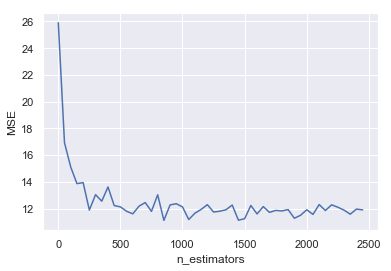

In [322]:
# iterate through n_estimators to find the optimal parameter value.
n_estimator = range(1,2500, 50)
test_results = []
for estimator in n_estimator:
   bst = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123),
                          n_estimators=estimator, learning_rate = 0.05)
   bst.fit(X_train, y_train)
   y_pred = bst.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_results.append(mse)
plt.plot(n_estimator, test_results)
plt.ylabel('MSE')
plt.xlabel('n_estimators')
sns.set(font_scale = 1)

- MSE appears to have settled down around n_estimator = 2000.
- We will run a Boosting models using n_estimator = 2000
- Below we also try fine tuning the `learning_rate` hyperparameter. Learning_rate is the contribution of each model to the weights and defaults to 1. Reducing the learning rate will mean the weights will be increased or decreased to a small degree, forcing the model train slower (but sometimes resulting in better performance scores). 
- There is a trade-off between `n_estimators` and `learning_rate` and so fine tuning the parameter having set n_estimator = 2000 is necessary.
- Typical values for learning_rate is 0.001 or 0.01, the right choice will depend on the problem. Very small learning rate can require using very large value for n_estimator to achieve good performance.

In [ ]:
# due to limitations in computing power, we first iterate through learning_rate 0.001 to 0.2 in 0.001 incrementals.
# we save outcome in a dataframe 'test_boost'.
learning_rate = np.arange(0.001, 0.2, 0.001)
test_boost = pd.DataFrame({'learning_rate': [],'MSE': []})
for rate in pbar(learning_rate):
   bst = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123),
                          n_estimators=2000, learning_rate = rate)
   bst.fit(X_train, y_train)
   y_pred = bst.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_boost = test_boost.append({'learning_rate': rate, 'MSE': mse}, ignore_index=True)

In [ ]:
# we then iterate through learning_rate from 0.1 to 1 in 0.005 incrementals 
# and store outcome in a dataframe test_boost_2
learning_rate = np.arange(0.01, 1, 0.005)
test_boost_2 = pd.DataFrame({'learning_rate': [],'MSE': []})
for rate in pbar(learning_rate):
   bst = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123),
                          n_estimators=2000, learning_rate = rate)
   bst.fit(X_train, y_train)
   y_pred = bst.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)
   test_boost_2 = test_boost_2.append({'learning_rate': rate, 'MSE': mse}, ignore_index=True)


Text(0.5,0,'learning_rate')

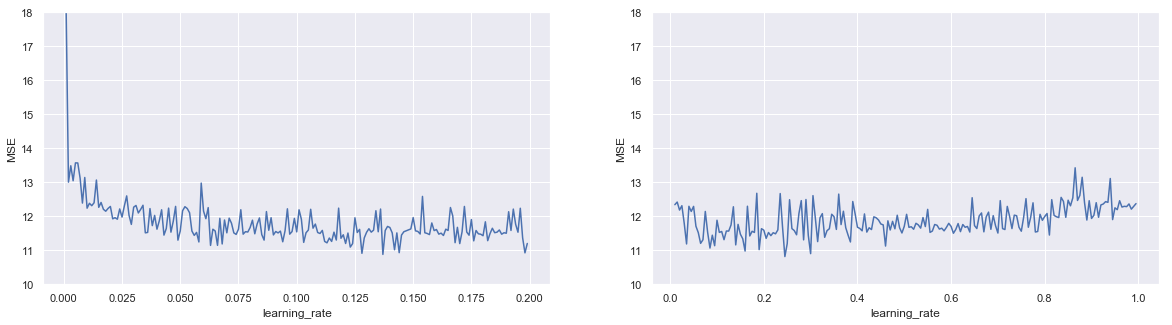

In [422]:
# we plot our results
f, axes = plt.subplots(1,2, figsize = (20,5))
# sns.distplot(df.price, ax=axes[0,0])
axes[0].plot(test_boost['learning_rate'], test_boost['MSE'])
axes[0].set_ylim(10,18)
axes[0].set_ylabel('MSE')
axes[0].set_xlabel('learning_rate')
axes[1].plot(test_boost_2['learning_rate'], test_boost_2['MSE'])
axes[1].set_ylim(10,18)
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('learning_rate')

In [421]:
print(test_boost.sort_values(by = 'MSE').head())
print(test_boost_2.sort_values(by = 'MSE').head())

     learning_rate        MSE
136          0.137  10.878137
127          0.128  10.910098
197          0.198  10.924216
143          0.144  10.929118
141          0.142  11.016373
    learning_rate        MSE
47          0.245  10.814804
58          0.300  10.900686
30          0.160  10.977549
36          0.190  11.019020
15          0.085  11.065196


We see from our plots, that 'MSE' reduces from 0 to 0.075 and increases after 0.8. From our tables, we see that the optimal 'learning_rate' for 'n_estimator = 2000' is 0.245. Below will run a Boosting model using n_estimator = 2000 and learning_rate = 0.245. 

Feature importance: 
lower_status          0.450052
avg_room              0.340964
jobcentre_distance    0.078369
crime_rate            0.027456
NOx                   0.026208
tax                   0.019710
age                   0.017887
pupilteacher          0.015093
black                 0.012159
non_retail_land       0.005269
highway_access        0.004719
large_resi            0.001230
river                 0.000885
dtype: float64
------------------------------
MSE:  11.5957843137
RMSE: 3.40525833289
%MAE:  10.6836326418


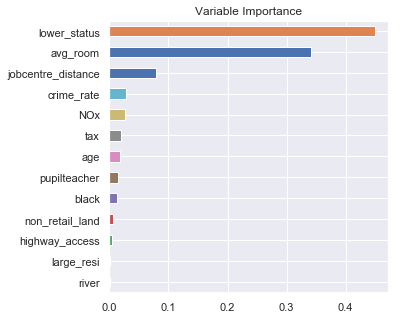

In [424]:
regr_boost = AdaBoostRegressor(tree.DecisionTreeRegressor(criterion = 'mse', random_state = 123),
                          n_estimators=2000, learning_rate = 0.245)

regr_boost.fit(X_train, y_train)
y_pred_boost = regr_boost.predict(X_test)
y_pred_boost = pd.Series(y_pred_boost)

# check which variables are the most important
feature_importances_boost = pd.Series(regr_boost.feature_importances_, index = X.columns)
feature_importances_boost = feature_importances_boost.sort_values()
print("Feature importance: ")
print(feature_importances_boost.sort_values(ascending = False))
print("------------------------------")

# take a look at the depth of the tree/number of nodes
print("MSE: ",  mean_squared_error(y_test, y_pred_boost))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_boost)))
print("%MAE: ", mean_absolute_percentage_error(y_test, y_pred_boost))

# visualise feature importance
feature_importances_boost.plot(kind = 'barh', figsize = (5,5))
plt.title("Variable Importance")
sns.set(font_scale = 1)

- The test set MSE associated with the Boosting model is 11.6. The sqrt of MSE is around 3.40, indicating that this model leads to test predictions that are within around $3,440 of the true median home value for the suburb. This equates to a %MAE of 10.6%.


- This is an improvement both vs. the unpruned decision tree model and the random forest model for prediction.


- `lower status` under this model is the most important factor (0.45), instead of `avg_room` (0.34) unlike in other models. `jobcentre_distance` remains the third most important factor, as was the case in our fully grown tree model and Random Forest model.

- We visualise and compare the predictive lower (MSE) of three models (fully grown tree, Random Forest and Boosting).

In [482]:
# combine y_test, y_pred_full (fully grown tree), y_pred_rf (random forest) and y_pred_boost (boosting) into one dataframe.
comp_y = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_full_df = pd.DataFrame(y_pred_full)
y_pred_rf_df = pd.DataFrame(y_pred_rf)
y_pred_boost_df = pd.DataFrame(y_pred_boost)

df_obs_pred = pd.concat([comp_y,y_pred_full_df], ignore_index = True, axis=1)
df_obs_pred = pd.concat([df_obs_pred,y_pred_rf_df], axis = 1, ignore_index=True)
df_obs_pred = pd.concat([df_obs_pred,y_pred_boost_df], axis = 1, ignore_index=True)
df_obs_pred.columns = ['y_test', 'y_pred_full', 'y_pred_rf', 'y_pred_boost']
df_obs_pred.head()


,y_test,y_pred_full,y_pred_rf,y_pred_boost
0,15.0,50.0,32.2692,23.1
1,26.6,28.4,27.1854,28.0
2,45.4,48.5,48.0150,50.0
3,20.8,21.9,20.5754,21.4
4,34.9,31.2,30.9268,31.1


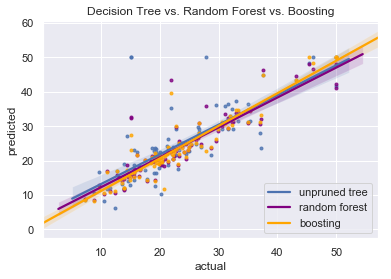

In [483]:
# regplot predicted and actual housing prices
sns.regplot(x='y_test', y='y_pred_full', data=df_obs_pred, marker='.')
sns.regplot(x='y_test', y='y_pred_rf', data=df_obs_pred, color='purple', marker='.')
sns.regplot(x='y_test', y='y_pred_boost', data=df_obs_pred, color='orange', marker='.')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("Decision Tree vs. Random Forest vs. Boosting")
plt.legend(labels=['unpruned tree','random forest', 'boosting'])

## 6. Evaluation and Conclusion

**[Conclusions to data question #1]** 
- We tested and tuned 3 sets of models: simple decision tree, Random Forest, and Boosting.
- The Boosting model (which is our preferred model with the lowest RMSE and good model stability) yielded RMSE of $3400; %MAE of 10.7%, which does not meet our accuracy requirement set out in the brief. 
- We suggest ways of further improving predictions below. 

**[Conclusions to data question #2]**
- `avg_room`, `lower_status` and `jobcentre_distance` are the top 3 factors contributing to house prices in Boston. This is supported by three models we ran: fully-grown tree (13 variables), Random Forest (13 variables) and Boosting (13 variables).
- All three variables reflect the purchasing power of households.  
- Based on `feature_importance` metric of our tuned Boosting model, `lower_status` was the most important factor, followed by `avg_room` and `jobcentre_distance`  
----------------------------------- <br>
lower_status          0.450052 <br>
avg_room              0.340964 <br>
jobcentre_distance    0.078369 <br>
----------------------------------- <br>
- `lower_status` and `avg_room` had the highest correlaton to `price` (see Section 4.2 Correlation Analysis)
- `jobcentre_distance` at 0.25 was less correlated to `price` vs. other feature variables. This is potentially due to the high correlation `jobcentre_distance` had with other feature variables and so was a good 'catch-all' term. This requires further study.


**[Avenues for further study and limitations of model]**
- To further improve the predictions, we would need more observations to train the model (we only had 506 observations to work with). 
- It may also be worthwhile to source data on new variables, which explains the target variable better: e.g. value of household income (based on fact that the top 3 features identified here all relates to household purchasing power). 

- Further, today's average price of owner-occupied homes in Boston is north of $600k. In order for our model to be applicable for use today, we would need to either find more recent data or inflate predicted prices to today's level (this latter would however introduce more error and bias into our prediction).